# Validación de los modelos

In [1]:
import keras
import joblib
import sent2vec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
data_test = pd.read_csv('test_Data.csv', sep=',', encoding = 'utf-8')
data_test.drop(["Unnamed: 0"], axis = 1)
X_test = data_test["tokenized_abstracts"]
Y_test = data_test['problems_described']

## Validación Multinomial Naive Bayes

In [3]:
file_name_modelo_mnb = "multinomial_nb.joblib"

modelo_mnb = joblib.load(file_name_modelo_mnb)

Y_predicted_problems_mnb = modelo_mnb.predict(X_test)

In [4]:
modelo_mnb.score(X_test, Y_test)

0.56

In [5]:
print(classification_report(Y_test, Y_predicted_problems_mnb))

              precision    recall  f1-score   support

           1       0.64      0.80      0.71       526
           2       0.56      0.56      0.56       248
           3       0.47      0.46      0.46       320
           4       0.54      0.85      0.66       507
           5       0.55      0.26      0.35       799

    accuracy                           0.56      2400
   macro avg       0.55      0.59      0.55      2400
weighted avg       0.56      0.56      0.53      2400



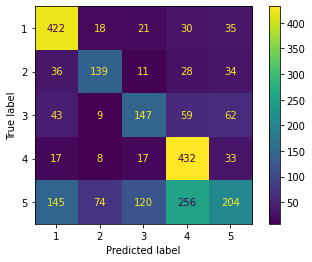

In [6]:
cm_2 = confusion_matrix(Y_test, Y_predicted_problems_mnb)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels= np.arange(1,6))
disp_2.plot()
plt.show()

## Validación OneVSRest

In [7]:
file_name_modelo_ovr = "OneVsRest.joblib"

modelo_ovr = joblib.load(file_name_modelo_ovr)

Y_predicted_problems_ovr = modelo_ovr.predict(X_test)

In [8]:
modelo_ovr.score(X_test, Y_test)

0.54875

In [9]:
print(classification_report(Y_test, Y_predicted_problems_ovr))

              precision    recall  f1-score   support

           1       0.68      0.80      0.74       526
           2       0.47      0.81      0.60       248
           3       0.41      0.83      0.55       320
           4       0.61      0.83      0.71       507
           5       1.00      0.00      0.01       799

    accuracy                           0.55      2400
   macro avg       0.63      0.66      0.52      2400
weighted avg       0.71      0.55      0.45      2400



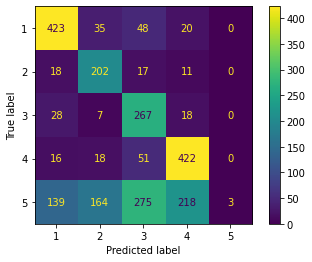

In [10]:
cm = confusion_matrix(Y_test, Y_predicted_problems_ovr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= np.arange(1,6))
disp.plot()
plt.show()

## Validación LSTM

In [11]:
modelo_lstm = "model_94.h5"

Debido a que este modelo usa un embedding especial que no puede utilizarse en una pipeline, debemos traerlo al notebook de validación. Así,

In [12]:
model_path = 'BioSentVec_PubMed_MIMICIII-bigram_d700.bin'
model = sent2vec.Sent2vecModel()
try:
    model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


Asimismo, aplicamos las transformaciones necesarias. Las labels de Y las volvemos One-Hot también.

In [13]:
embedded_abstracts = model.embed_sentences(data_test['non_tokenized_abstracts'])
embedded_abstracts = embedded_abstracts.reshape(-1, 1, embedded_abstracts.shape[1])

In [14]:
Y_test = keras.utils.np_utils.to_categorical(Y_test)[:,1:]

Ahora cargamos el modelo y predecimos:

In [15]:
lstm = load_model(modelo_lstm)

2022-03-28 23:41:32.857502: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
y_pred = lstm.predict(embedded_abstracts)
y_pred = y_pred.argmax(1) + 1 # Sumamos 1 para que las clases nos queden entre 1 y 5 
Y_test = Y_test.argmax(1) + 1 # Sumamos 1 para que las clases nos queden entre 1 y 5 

In [17]:
print('---Reporte para el modelo construido---')
print(classification_report(Y_test, y_pred))

---Reporte para el modelo construido---
              precision    recall  f1-score   support

           1       0.73      0.81      0.77       526
           2       0.47      0.75      0.58       248
           3       0.51      0.69      0.58       320
           4       0.67      0.83      0.74       507
           5       0.66      0.30      0.41       799

    accuracy                           0.62      2400
   macro avg       0.61      0.67      0.62      2400
weighted avg       0.64      0.62      0.60      2400



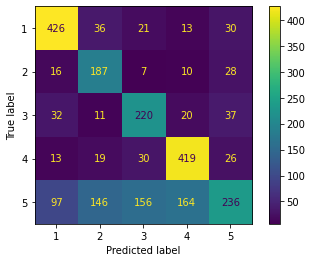

In [18]:
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= np.arange(1,6))
disp.plot()
plt.show()